## Initialization

In [1]:
using Pkg
Pkg.activate("../one_flav_env")

using LHEF
using LorentzVectorHEP
using DataFrames
using CSV
using StaticArrays
using LinearAlgebra
using LaTeXStrings
using DelimitedFiles: readdlm
using Optim
using PythonPlot

golden_ratio = (1+sqrt(5))/2

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")

MG_RESULTS_DIR = "../madgraph/"
FIGDIR = "./"

# make sure these match what the script has output
DIR_llνν = MG_RESULTS_DIR * "mumu_to_llvv/"
DIR_φφ = MG_RESULTS_DIR * "mumu_to_phiphi/"
DIR_llχχ = MG_RESULTS_DIR * "mumu_to_llchichi/"
DIR_VVφφ = MG_RESULTS_DIR * "VV_to_phiphi/"
DIR_VVχχ = MG_RESULTS_DIR * "VV_to_llchichi/"

XSEC_RESULTS_FILENAME = "xsec.txt"
LHE_FILENAME = "unweighted_events.lhe.gz"

function dir_runx(x)
    if x < 10
        return "Events/run_0$x/"
    else
        return "Events/run_$x/"
    end
end
;

  Activating project at `~/Dropbox (University of Oregon)/MuC/Aria/one_flav/code/one_flav_env`


### General functions:

In [2]:
lhe_v4(p) = LorentzVector(p.e, p.px, p.py, p.pz)
lhe_v3(p) = SA[p.px, p.py, p.pz]
lhe_pt(p) = SA[p.px, p.py]

function trans_mass(pT1, pT2, m1, m2)
    ET1 = sqrt((pT1 ⋅ pT1) + m1^2)
    ET2 = sqrt((pT2 ⋅ pT2) + m2^2)
    return m1^2 + m2^2 + 2*(ET1*ET2 - (pT1 ⋅ pT2))
end

function MT2(particle_1, particle_2)
    p1 = lhe_v4(particle_1)
    p2 = lhe_v4(particle_2)

    m1 = particle_1.m
    m2 = particle_2.m

    pT1 = lhe_pt(particle_1)
    pT2 = lhe_pt(particle_2)
    pt_miss = -(pT1 .+ pT2)
    init_x = MArray{Tuple{2}}(pt_miss) ./ 2

    function mt_to_min(x)
        ET1 = sqrt((pT1 ⋅ pT1) + m1^2)
        ET2 = sqrt((pT2 ⋅ pT2) + m2^2)
        return max(trans_mass(pT1, x, m1, 0), trans_mass(pT2, pt_miss-x, m2, 0))
    end

    # res = optimize(mt_to_min, init_x, LBFGS(); autodiff=:forward)
    res = optimize(mt_to_min, init_x, NelderMead())

    return sqrt(minimum(res))
end

function find_leptons(event)
    idxs = Vector{Int64}()
    for p in event.particles[3:end]
        if p.id in [11,-11,13,-13]
            append!(idxs, p.idx)
        end
    end
    return idxs
end

function check_leptons(events)
    for (i,e) in enumerate(events)
        if length(find_leptons(e)) > 2
            throw(ArgumentError("Too many leptons in event $i"))
        end
    end
end

function dilepton_summarize(event::LHEF.Event)
    l_idx = find_leptons(event)

    p1 = lhe_v4(event.particles[l_idx[1]])
    p2 = lhe_v4(event.particles[l_idx[2]])

    p1_3 = lhe_v3(event.particles[l_idx[1]])
    p2_3 = lhe_v3(event.particles[l_idx[2]])

    inv_mass = mass(p1+p2)
    pT = pt(p1+p2)
    open_angle = (p1_3 ⋅ p2_3) / (norm(p1_3)*norm(p2_3))
    deltaR = ΔR(p1, p2)
    mt2 = MT2(event.particles[l_idx[1]], event.particles[l_idx[2]])
    
    return [inv_mass, pT, open_angle, deltaR, mt2]
end

function dilepton_summarize(lhe::Vector{LHEF.Event})
    N_events = length(lhe)

    res = zeros(Float64, (N_events, 5))

    @Threads.threads for i in 1:N_events
        res[i,:] = dilepton_summarize(lhe[i])
    end

    res = Matrix(res')

    return res
end

function dilepton_pT(event)
    l_idx = find_leptons(event)

    p1 = lhe_v4(event.particles[l_idx[1]])
    p2 = lhe_v4(event.particles[l_idx[2]])

    return pt(p1+p2)
end
;

### Functions that act on a single run:

In [3]:
function get_rts(rundir)
    n_run = rundir[end-2:end-1]
    f = open(rundir * "run_$(n_run)_tag_1_banner.txt")
    l = ""
    for line in eachline(f)
        if occursin("ebeam1",line)
            l *= line
            break
        end
    end
    close(f)
    return 2*parse(Float64, strip(split(l,"\t")[1]))
end

function get_mphi(rundir)
    if isfile(rundir * "params.dat")
        f = open(rundir * "params.dat")
        l = ""
        for line in eachline(f)
            if occursin("msca",line)
                l *= line
                break
            end
        end
        close(f)
        return parse(Float64, strip(split(l,"=")[2]))
    else
        return 0.0
    end
end

get_events(rundir) = parse_lhe(rundir * LHE_FILENAME)

function get_xsec(rundir)
    xsec_fname = rundir[1:end-14] * XSEC_RESULTS_FILENAME
    n_run = parse(Int64, rundir[end-2:end-1])
    return readdlm(xsec_fname, skipstart=1)[n_run,3]
end
;

### Functions that act on a MG output directory:

In [4]:
function count_runs(mg_proc_dir)
    n_run = 0
    for ff in readdir(mg_proc_dir * "Events/")
        if isdir(mg_proc_dir * "Events/" * ff)
            n_run += 1
        end
    end
    return n_run
end

function get_all(fn, mg_proc_dir)
    n_run = count_runs(mg_proc_dir)

    placehold = Vector{Any}()

    for i in 1:n_run
        rundir = dir_runx(i)
        push!(placehold, fn(mg_proc_dir * rundir))
    end

    results = Vector{typeof(placehold[1])}(placehold)

    return results
end

function get_runs_at_rts(rts_tev; bkg_dir=DIR_llνν, sig_dirs=(DIR_llχχ, DIR_VVχχ), 
    φφ_dirs=(DIR_φφ, DIR_VVφφ))

    bkg_rts = get_all(get_rts, bkg_dir)
    sig_rts = get_all(get_rts, sig_dirs[1])
    sig_vv_rts = get_all(get_rts, sig_dirs[2])

    rts_gev = Float64(rts_tev)*1e3

    bkg_idxs = findall(x -> x == rts_gev, bkg_rts)
    sig_idxs = findall(x -> x == rts_gev, sig_rts)
    sig_vv_idxs = findall(x -> x == rts_gev, sig_vv_rts)

    bkg_rundir = bkg_dir * dir_runx(bkg_idxs[1])
    sig_rundirs = sig_dirs[1] .* dir_runx.(sig_idxs)
    sig_vv_rundirs = sig_dirs[2] .* dir_runx.(sig_vv_idxs)

    mumu_xsecs = get_all(get_xsec, φφ_dirs[1])[sig_idxs]
    vv_xsecs = get_all(get_xsec, φφ_dirs[2])[sig_idxs]

    N_runs_mumu = length(sig_rundirs)
    N_runs_vv = length(sig_vv_rundirs)

    mphis = zeros(Float64, N_runs_mumu)
    mphis_vv = zeros(Float64, N_runs_vv)
    events = Vector{Vector{LHEF.Event}}(undef, N_runs_mumu)
    events_vv = Vector{Vector{LHEF.Event}}(undef, N_runs_vv)

    for (i, sig_rundir) in enumerate(sig_rundirs)
        mphis[i] = get_mphi(sig_rundir)
        events[i] = get_events(sig_rundir)
    end

    for (i, sig_vv_rundir) in enumerate(sig_vv_rundirs)
        mphis_vv[i] = get_mphi(sig_vv_rundir)
        events_vv[i] = get_events(sig_vv_rundir)
    end

    bkg_events = get_events(bkg_rundir)
    bkg_xsec = get_xsec(bkg_rundir)

    # check_leptons.(events)
    # check_leptons.(events_vv)
    # check_leptons(bkg_events)

    N_events_mumu = length(events[1])
    N_events_vv = length(events_vv[1])

    mumu_summaries = Vector{Matrix{Float64}}(undef, N_runs_mumu)
    vv_summaries = Vector{Matrix{Float64}}(undef, N_runs_vv)

    @Threads.threads for i in 1:length(events)
        mumu_summaries[i] = dilepton_summarize(events[i])
    end

    @Threads.threads for i in 1:length(events_vv)
        vv_summaries[i] = dilepton_summarize(events_vv[i])
    end

    bkg_summary = dilepton_summarize(bkg_events)

    if mphis == mphis_vv
        return (rts=rts_gev, mphis=mphis, bkg_summary=bkg_summary, 
                bkg_xsec=bkg_xsec, bkg_events=bkg_events, 
                mumu_summaries=mumu_summaries, mumu_xsecs=mumu_xsecs, 
                mumu_events=events, vv_summaries=vv_summaries, 
                vv_xsecs=vv_xsecs, vv_events=events_vv)
    else
        throw(ArgumentError("mphis don't match!"))
    end
end
;

In [5]:
rts10_runs = get_runs_at_rts(10)
# rts6_runs = get_runs_at_rts(6)
rts3_runs = get_runs_at_rts(3)
;

## Histograms:

### Histograms of a single $\sqrt{s}$:

In [8]:
function run_hist(rts_runs; nbins=50)
    mumu_summaries = rts_runs.mumu_summaries
    vv_summaries = rts_runs.vv_summaries
    bkg_summary = rts_runs.bkg_summary

    title = L"$\mu^+ \mu^- \to l^+ l^- + \slashed{E}_T$ ($\sqrt{s} = %$(1e-3*rts_runs.rts)$ TeV)"
    labels = ["Background"]

    for m in rts_runs.mphis
        push!(labels, L"Signal, $m_\phi = %$(1e-3*m)$ TeV")
    end

    yscales = ["log", "log", "log", "linear", "log"]
    xlabels = [L"$m_{ll}$ [GeV]", L"$p_{T,ll}$ [GeV]", L"\cos(\theta_{ll})", 
                L"\Delta R_{ll}", L"$M_{T2}$ [GeV]"]

    colors = ["tab:blue", "tab:orange", "tab:red"]
    linestyles = ["solid", "dashed"]
    
    fig, axs = subplots(3,2, figsize=(8, 8))

    iter = 1
    for ax in axs
        for a in ax
            if iter == 6
                a.remove()
                break
            end
            
            eachmin = [minimum(sig_summ[iter,:]) for sig_summ in mumu_summaries]
            eachmin2 = [minimum(sig_summ[iter,:]) for sig_summ in vv_summaries]
            binmin = min(eachmin..., eachmin2..., minimum(bkg_summary[iter,:]))

            eachmax = [maximum(sig_summ[iter,:]) for sig_summ in mumu_summaries]
            eachmax2 = [maximum(sig_summ[iter,:]) for sig_summ in vv_summaries]
            binmax = max(eachmax..., eachmax2..., maximum(bkg_summary[iter,:]))

            binns = range(binmin, binmax, nbins)

            a.hist(bkg_summary[iter,:], bins=binns, color="grey",
                histtype="step", density=true)

            for (i,sig_summ) in enumerate(mumu_summaries)
                a.hist(sig_summ[iter,:], bins=binns, color=colors[i],
                    linestyle=linestyles[1], histtype="step", density=true)
            end

            for (i,sig_summ) in enumerate(vv_summaries)
                a.hist(sig_summ[iter,:], bins=binns, color=colors[i],
                    linestyle=linestyles[2], histtype="step", density=true)
            end
            
            a.set_yscale(yscales[iter])

            a.set_xlabel(xlabels[iter])
            a.set_ylabel("Probability Density")

            a.grid(alpha=0.3)
            iter += 1
        end
    end

    axs[0,0].plot(0, Inf, lw=1., c="grey", label=labels[1])
    for i in 1:length(mumu_summaries)
        axs[0,0].plot(0, Inf, lw=1., c=colors[i], label=labels[i+1])
    end
    axs[0,0].plot(0, Inf, lw=1., c="black", label=L"i = \mu^+ \mu^-")
    axs[0,0].plot(0, Inf, lw=1., c="black", ls="dashed", label=L"i = V V")

    handles, labels = axs[0,0].get_legend_handles_labels()

    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=14)

    fig.suptitle(title)

    tight_layout(rect=(0, .08, 1, 1))

    plotclose()
    return fig
end

function run_hist_3(rts_runs_1, rts_runs_2; binsize=[50, 100])
    mphi_idxs_1 = [1,length(rts_runs_1.mphis)]
    mphi_idxs_2 = [1,length(rts_runs_2.mphis)]

    mumu_summaries = [rts_runs_1.mumu_summaries[mphi_idxs_1],
                      rts_runs_2.mumu_summaries[mphi_idxs_2]]
    vv_summaries = [rts_runs_1.vv_summaries[mphi_idxs_1],
                    rts_runs_2.vv_summaries[mphi_idxs_2]]
    bkg_summary = [rts_runs_1.bkg_summary, rts_runs_2.bkg_summary]

    stitle = L"i \to l^+ l^- + \slashed{E}_T"
    labels = ["Background"]

    mphis = unique(vcat(rts_runs_1.mphis[mphi_idxs_1],
                        rts_runs_2.mphis[mphi_idxs_2]))

    for m in mphis
        push!(labels, L"Signal, $m_\phi = %$(1e-3*m)$ TeV")
    end

    yscales = ["log", "log", "log"]
    xlabels = [L"$m_{\ell \ell}$ [TeV]", L"$p_{T,\ell \ell}$ [TeV]", L"$M_{T2}$ [TeV]"]
    ylims = [(1e1, 1e5), (1e1, 1e5), (1e1, 1e5)]

    colors = [["tab:blue", "tab:orange"], ["tab:blue", "tab:red"]]
    linestyles = ["solid", "dashed"]
    
    fig, axs = subplots(3,2, figsize=(9, 9))
    # fig, axs = subplots(1,3, figsize=(15, 5))

    s_i = [1,2,5]
    iter = 1
    for ax in axs
        for (j,a) in enumerate(ax)
            
            eachmin = [minimum(sig_summ[s_i[iter],:]) for sig_summ in mumu_summaries[j]]
            eachmin2 = [minimum(sig_summ[s_i[iter],:]) for sig_summ in vv_summaries[j]]
            binmin = min(eachmin..., eachmin2..., minimum(bkg_summary[j][s_i[iter],:]))

            eachmax = [maximum(sig_summ[s_i[iter],:]) for sig_summ in mumu_summaries[j]]
            eachmax2 = [maximum(sig_summ[s_i[iter],:]) for sig_summ in vv_summaries[j]]
            binmax = max(eachmax..., eachmax2..., maximum(bkg_summary[j][s_i[iter],:]))

            binns = 1e-3 .* range(0, binmax+binsize[j]; step=binsize[j])

            a.hist(1e-3 .* bkg_summary[j][s_i[iter],:], bins=binns, color="grey",
                histtype="step", density=false)

            for (i,sig_summ) in enumerate(mumu_summaries[j])
                a.hist(1e-3 .* sig_summ[s_i[iter],:], bins=binns, color=colors[j][i],
                    linestyle=linestyles[1], histtype="step", density=false)
            end

            for (i,sig_summ) in enumerate(vv_summaries[j])
                a.hist(1e-3 .* sig_summ[s_i[iter],:], bins=binns, color=colors[j][i],
                    linestyle=linestyles[2], histtype="step", density=false)
            end
            
            a.set_yscale(yscales[iter])

            a.set_xlabel(xlabels[iter])
            # a.set_xlabel(xlabels[iter] * " (binsize = $(round(1e3*(binns[2]-binns[1]), sigdigits=4)) [GeV])")
            a.set_ylabel("Number of Events")

            a.grid(alpha=0.3)

            # a.set_xlim((1e-3*binmin, binns[end]))
            a.set_xlim((0, binns[end]))
            a.set_ylim(ylims[iter])
            # iter+=1
        end
        iter += 1
    end

    axs[0,0].plot(0, Inf, lw=1., c="grey", label=labels[1])
    for i in eachindex(mphis)
        axs[0,0].plot(0, Inf, lw=1., c=["tab:blue", "tab:orange", "tab:red"][i], label=labels[i+1])
    end
    # for i in 1:(length(mphis)-1)
    #     axs[0,0].plot(0, Inf, lw=1., c=["tab:blue", "tab:orange", "tab:red"][i], label=labels[i+1])
    # end
    axs[0,0].plot(0, Inf, lw=1., c="black", label=L"i = \mu^+ \mu^-")
    axs[0,0].plot(0, Inf, lw=1., c="black", ls="dashed", label=L"$i = $VBF")

    handles, labels = axs[0,0].get_legend_handles_labels()

    axs[0,0].set_title(L"$\sqrt{s} = %$(rts_runs_1.rts*1e-3)$ TeV")
    axs[0,1].set_title(L"$\sqrt{s} = %$(rts_runs_2.rts*1e-3)$ TeV")

    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=12)

    # fig.suptitle(stitle)

    tight_layout(rect=(0, .05, 1, 1.02))
    # tight_layout(rect=(0, .12, 1, 1))

    plotclose()
    return fig
end

run_hist_rts(rts_tev; nbins=50) = run_hist(get_runs_at_rts(rts_tev); nbins=nbins)
;

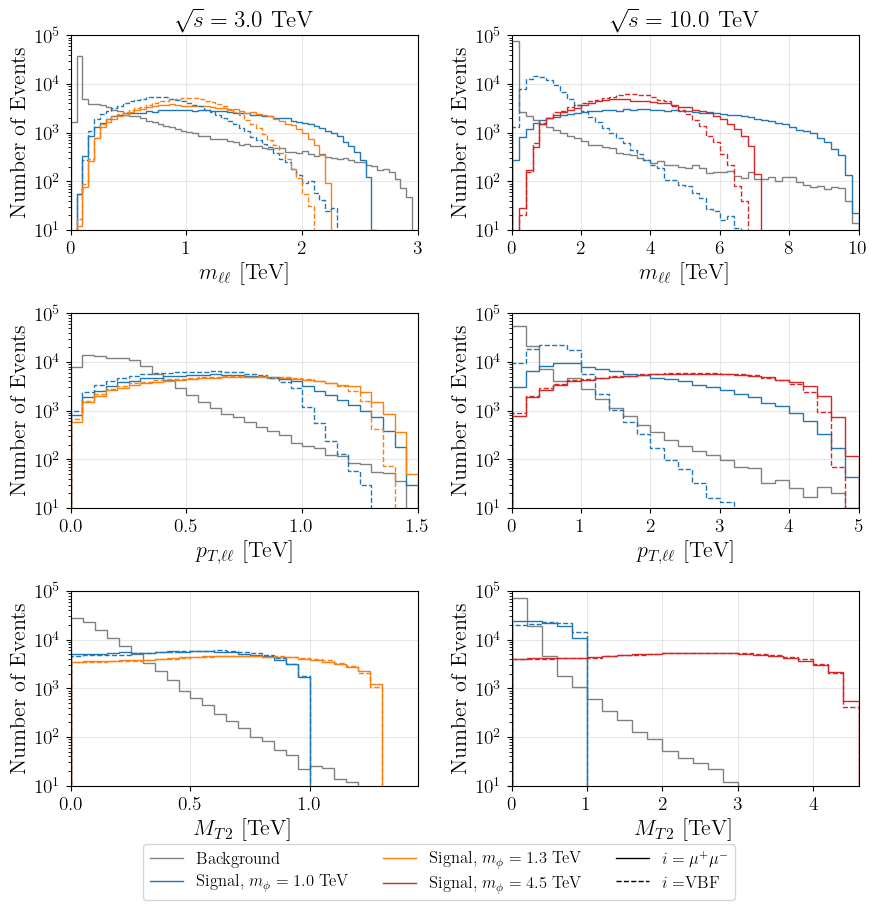

In [10]:
hist_fig_3 = run_hist_3(rts3_runs, rts10_runs; binsize=[50,200])
hist_fig_3.savefig(FIGDIR * "prompt_1d_hist.pdf", bbox_inches="tight")
hist_fig_3

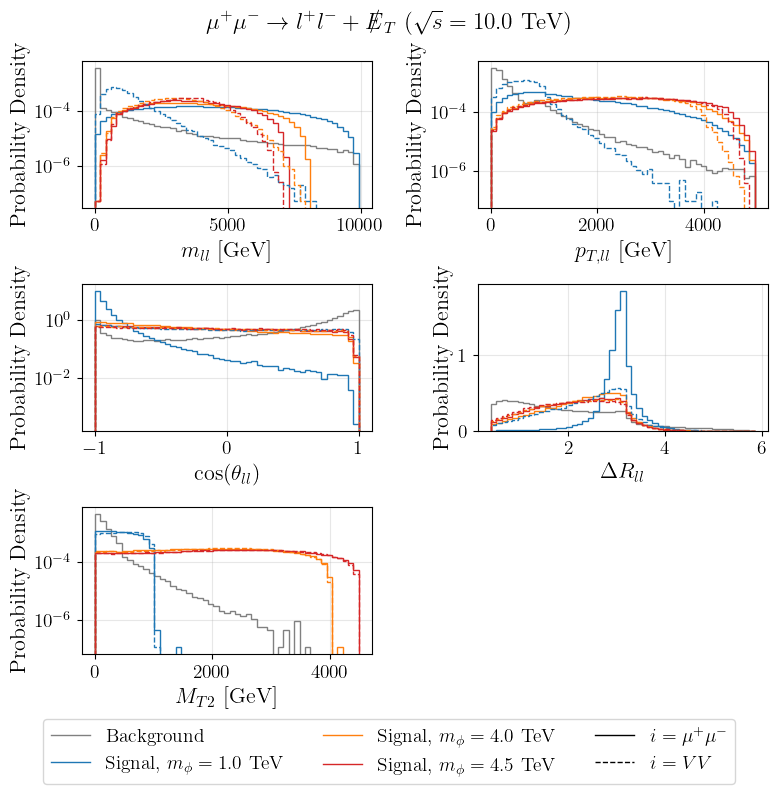

In [7]:
hist_fig = run_hist(rts10_runs)
# hist_fig.savefig(FIGDIR * "hist_mt2_rts=3.pdf")
hist_fig

## Impact of Cuts:

### Individually:

In [28]:
function fraction_cut(summary, cuts)
    Nevent = length(summary[1,:])

    mll_res = [sum(summary[1,:] .> mll_min)/Nevent for mll_min in cuts[1]]
    pt_res = [sum(summary[2,:] .> pt_min)/Nevent for pt_min in cuts[2]]
    cosθ_res = [sum(summary[3,:] .< cθ)/Nevent for cθ in cuts[3]]
    ΔR_res = [sum(summary[4,:] .> ΔR)/Nevent for ΔR in cuts[4]]
    MT2_res = [sum(summary[5,:] .> mt2)/Nevent for mt2 in cuts[5]]
    
    return (mll_res, pt_res, cosθ_res, ΔR_res, MT2_res)
end

function make_cuts_plot(rts_runs, lumi; ncuts=100)

    cuts = (range(0, rts_runs.rts, ncuts), range(0, rts_runs.rts/2, ncuts), 
            range(-1, 1, ncuts), range(0, 5, ncuts), 
            range(0, maximum(rts_runs.mphis), ncuts))

    mumu_fracs = fraction_cut.(rts_runs.mumu_summaries, (cuts,))
    vv_fracs = fraction_cut.(rts_runs.vv_summaries, (cuts,))
    bkg_fracs = fraction_cut(rts_runs.bkg_summary, cuts)

    background_err = [sqrt.(rts_runs.bkg_xsec.*lumi.*cutfrac) for cutfrac in 
                    bkg_fracs]
    Nevent_mumu = [[rts_runs.mumu_xsecs[i].*lumi.*cutfrac for cutfrac in 
                    mumu_fracs[i]] for i in 1:length(mumu_fracs)]
    Nevent_vv = [[rts_runs.vv_xsecs[i].*lumi.*cutfrac for cutfrac in
                    vv_fracs[i]] for i in 1:length(vv_fracs)]

    xlabels = [L"$m_{ll}$ min [GeV]", L"$p_{T,ll}$ min [GeV]", 
                L"$\cos(\theta_{ll})$ max", L"$\Delta R_{ll}$ min",
                L"$M_{T2}$ min [GeV]"]
    
    colors = ["tab:blue", "tab:orange", "tab:red"]

    fig, axs = subplots(3,2, figsize=(8, 8))

    iter = 1
    for ax in axs
        for a in ax
            if iter == 6
                a.remove()
                break
            end
            
            for i in 1:length(mumu_fracs)
                a.plot(cuts[iter], (Nevent_mumu[i][iter] .+ Nevent_vv[i][iter])
                    ./ background_err[iter], color=colors[i])
            end

            a.set_xlabel(xlabels[iter])
            a.set_ylabel(L"N_S / \sqrt{N_B}")

            a.grid(alpha=0.3)
            iter += 1
        end
    end

    for i in 1:length(mumu_fracs)
        axs[0,0].plot(0, Inf, lw=1., c=colors[i],
        label=L"$m_\phi = %$(1e-3*rts_runs.mphis[i])$ TeV")
    end

    handles, labels = axs[0,0].get_legend_handles_labels()

    fig.legend(handles, labels, loc="lower center", ncol=3)

    fig.suptitle(L"Impact of cuts on $\mu^+ \mu^- \to l^+ l^- + \slashed{E}_T$ incl. $VV$ ($\sqrt{s} = %$(1e-3*rts_runs.rts)$ TeV, $\mathcal{L} = %$(lumi*1e-6)$ ab$^{-1}$)")

    tight_layout(rect=(0, .04, 1, 1))

    plotclose()
    return fig
end

function make_cuts_plot_rts(rts, lumi; ncuts=100)
    make_cuts_plot(get_runs_at_rts(rts), lumi, ncuts=ncuts)
end
;

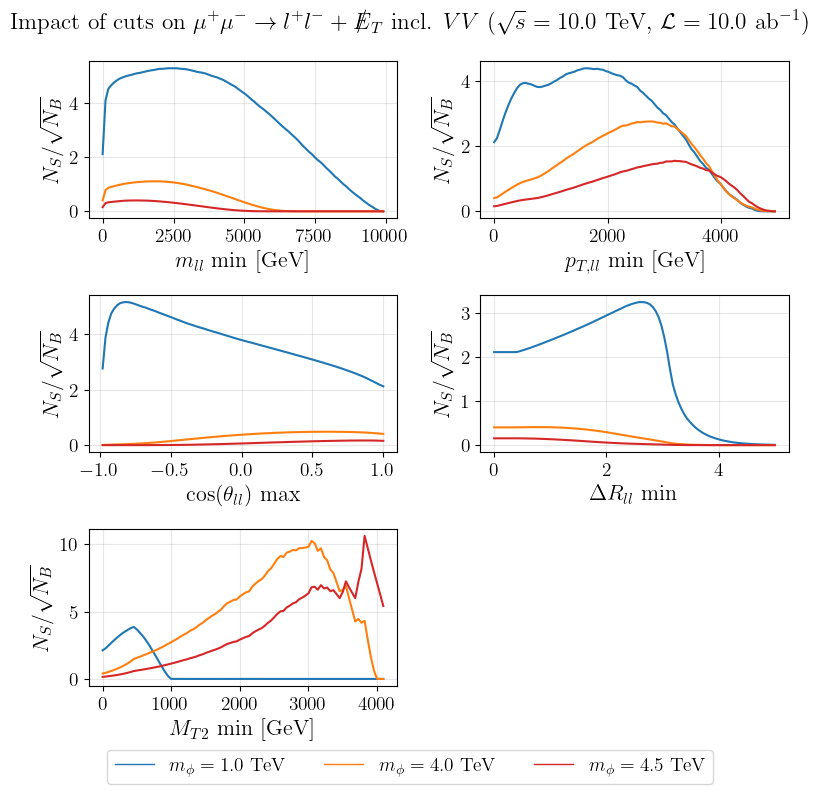

In [29]:
fig_cuts = make_cuts_plot(rts10_runs, 10e6)
# fig_cuts.savefig(FIGDIR * "cuts_wvv_mt2_rts=10.pdf")
fig_cuts

### Cross-cut:

In [187]:
function fraction_cut_cross(summary, idxs, mins)
    res = zeros(Float64, length.(mins))

    Nevent = length(summary[1,:])

    coefs = ones(Float64, 2)

    for i in 1:length(idxs)
        if idxs[i] == 3
            coefs[i] = -1
        end
    end

    @Threads.threads for i in 1:length(mins[1])
        for j in 1:length(mins[2])
            res[j,i] = sum((coefs[1]*summary[idxs[1],:] .> 
                        coefs[1]*mins[1][i]) .&& (coefs[2]*summary[idxs[2],:]
                        .> coefs[2]*mins[2][j]))
        end
    end
    return res ./ Nevent
end

function make_cross_cuts_plot(rts_runs, lumi, cut_idxs; ncuts=100)
    
    cuts = (range(0, rts_runs.rts, ncuts), range(0, rts_runs.rts/2, ncuts), 
        range(-1, 1, ncuts), range(0, 5, ncuts), 
        range(0, maximum(rts_runs.mphis), ncuts))[cut_idxs]
    
    N_mass = length(rts_runs.mphis)

    bkg_frac = fraction_cut_cross(rts_runs.bkg_summary, cut_idxs, cuts)

    background_err = sqrt.(rts_runs.bkg_xsec.*lumi.*bkg_frac)
    Nevent_mumu = [rts_runs.mumu_xsecs[i].*lumi.*fraction_cut_cross(
                    rts_runs.mumu_summaries[i], cut_idxs, cuts)
                    for i in 1:N_mass]
    Nevent_vv = [rts_runs.vv_xsecs[i].*lumi.*fraction_cut_cross(
                    rts_runs.vv_summaries[i], cut_idxs, cuts)
                    for i in 1:N_mass]

    labels = [L"$m_{ll}$ min [GeV]", L"$p_{T,ll}$ min [GeV]",   
            L"$\cos(\theta_{ll})$ max", L"$\Delta R_{ll}$ min",
            L"$M_{T2}$ min [GeV]"]

    if N_mass > 1
        fig, axs = subplots(1, N_mass, figsize=(4*N_mass,4))

        for i in 0:(N_mass-1)
            q = axs[i].contourf(cuts[1], cuts[2], (Nevent_mumu[i+1] .+
                Nevent_vv[i+1]) ./ background_err)

            axs[i].set_ylabel(labels[cut_idxs[2]])
            axs[i].set_xlabel(labels[cut_idxs[1]])

            axs[i].grid(alpha=0.3)

            axs[i].set_title(L"$m_\phi = %$(rts_runs.mphis[i+1]*1e-3)$ TeV")

            fig.colorbar(q)
        end
    else
        fig = figure()
        q = contourf(cuts[1], cuts[2], Nevent_sig[1] ./ background_err)

        ylabel(labels[cut_idxs[2]])
        xlabel(labels[cut_idxs[1]])

        grid(alpha=0.3)

        title(L"$m_\phi = %$(rts_runs.mphis[1]*1e-3)$ TeV")

        fig.colorbar(q)
    end

    fig.suptitle(L"Impact of cuts on $\mu^+ \mu^- \to l^+ l^- + \slashed{E}_T$ incl. $VV$ ($\sqrt{s} = %$(1e-3*rts_runs.rts)$ TeV, $\mathcal{L} = %$(lumi*1e-6)$ ab$^{-1}$)")

    plotclose()
    return fig
end

function make_cross_cuts_plot_rts(rts, lumi, cut_idxs; ncuts=100)
    make_cross_cuts_plot(get_runs_at_rts(rts), lumi, cut_idxs; ncuts=ncuts)
end
;

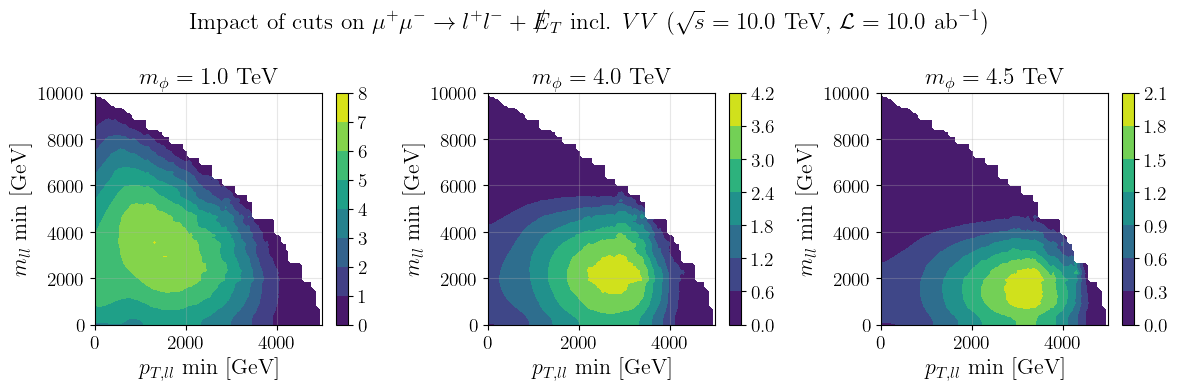

In [31]:
f_mll_ptll = make_cross_cuts_plot(rts10_runs, 10e6, [2,1])
# f_mll_ptll.savefig(FIGDIR * "mll_and_ptll_rts=10.pdf")
f_mll_ptll

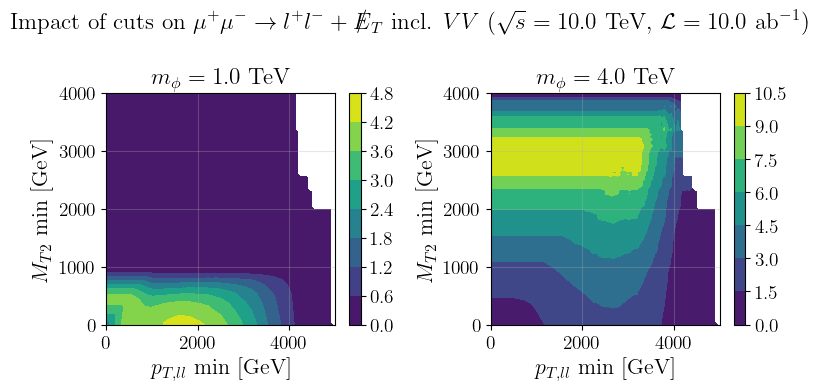

In [50]:
f_MT2_ptll = make_cross_cuts_plot(rts10_runs, 10e6, [2,5])
f_MT2_ptll.savefig(FIGDIR * "ptll_and_mt2_rts=10.pdf")
f_MT2_ptll

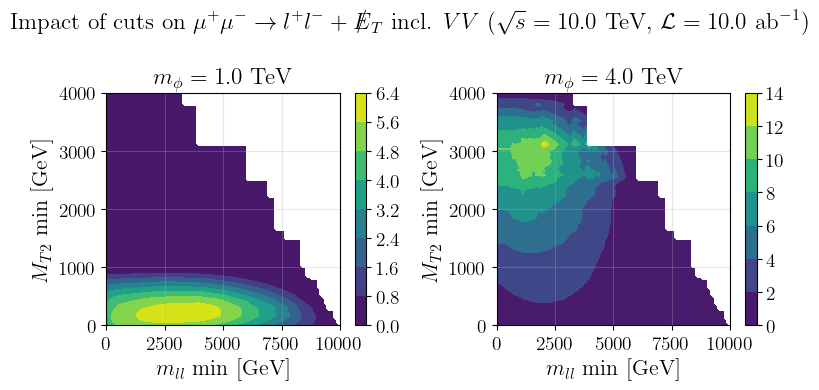

In [51]:
f_MT2_mll = make_cross_cuts_plot(rts10_runs, 10e6, [1,5])
f_MT2_mll.savefig(FIGDIR * "mll_and_mt2_rts=10.pdf")
f_MT2_mll

### Cross-cuts with third cut:

In [52]:
function fraction_cut_cross_2(summary, idxs, cross_mins, third_min)
    Nevent = length(summary[1,:])

    coefs = ones(Float64, 3)

    for i in 1:3
        if idxs[i] == 3
            coefs[i] = -1
        end
    end

    third_cuts_applied = (coefs[3] * summary[idxs[3],:] .> coefs[3] * third_min)

    return reduce(hcat, [[sum((coefs[2]*summary[idxs[2],:] .> coefs[2]*min1) .&& 
            (coefs[1]*summary[idxs[1],:] .> coefs[1]*min2) .&&
            third_cuts_applied)/Nevent for min1 in cross_mins[2]]
            for min2 in cross_mins[1]])
end

function make_cross_cuts_plot_2(rts_runs, lumi, cut_idxs, third_cut; ncuts=100)
    
    cuts = (range(0, rts_runs.rts, ncuts), range(0, rts_runs.rts/2, ncuts), 
        range(-1, 1, ncuts), range(0, 5, ncuts), 
        range(0, maximum(rts_runs.mphis), ncuts))[cut_idxs[1:2]]
    
    N_mass = length(rts_runs.mphis)

    background_err = [sqrt.(rts_runs.bkg_xsec.*lumi.*fraction_cut_cross_2(
                    rts_runs.bkg_summary, cut_idxs, cuts, third_cut[i]))
                    for i in 1:N_mass]
    Nevent_mumu = [rts_runs.mumu_xsecs[i].*lumi.*fraction_cut_cross_2(
                    rts_runs.mumu_summaries[i], cut_idxs, cuts, third_cut[i])
                    for i in 1:N_mass]
    Nevent_vv = [rts_runs.vv_xsecs[i].*lumi.*fraction_cut_cross_2(
                    rts_runs.vv_summaries[i], cut_idxs, cuts, third_cut[i])
                    for i in 1:N_mass]

    labels = [L"$m_{ll}$ min [GeV]", L"$p_{T,ll}$ min [GeV]",   
            L"$\cos(\theta_{ll})$ max", L"$\Delta R_{ll}$ min",
            L"$M_{T2}$ min [GeV]"]
    
    cut3_label = [L"$m_{ll}$ min", L"$p_{T,ll}$ min",
            L"$\cos(\theta_{ll})$ max", L"$\Delta R_{ll}$ min",
            L"$M_{T2}$ min"][cut_idxs[3]]
    
    cut3_units = ["TeV", "TeV", "", "", "TeV"][cut_idxs[3]]

    cut3_scaler = [1e-3, 1e-3, 1.0, 1.0, 1e-3][cut_idxs[3]]

    cut3_string = [L"%$(cut3_label) = %$(cut3_scaler*third_cut[1]) %$(cut3_units)",
                   L"%$(cut3_label) = %$(cut3_scaler*third_cut[2]) %$(cut3_units)"]

    if N_mass > 1
        fig, axs = subplots(1, N_mass, figsize=(4*N_mass,4))

        for i in 0:(N_mass-1)
            q = axs[i].contourf(cuts[1], cuts[2], (Nevent_mumu[i+1] .+
                Nevent_vv[i+1]) ./ background_err[i+1])

            axs[i].set_ylabel(labels[cut_idxs[2]])
            axs[i].set_xlabel(labels[cut_idxs[1]])

            axs[i].grid(alpha=0.3)

            axs[i].set_title(L"$m_\phi = %$(rts_runs.mphis[i+1]*1e-3)$ TeV (%$(cut3_string[i+1]))", fontsize=12)

            fig.colorbar(q)
        end
    else
        fig = figure()
        q = contourf(cuts[1], cuts[2], (Nevent_mumu[1] .+ Nevent_vv[1]) ./ 
            background_err[1])

        ylabel(labels[cut_idxs[2]])
        xlabel(labels[cut_idxs[1]])

        grid(alpha=0.3)

        title(L"$m_\phi = %$(rts_runs.mphis[1]*1e-3)$ TeV (%$(cut3_string[1]))")

        fig.colorbar(q)
    end

    fig.suptitle(L"Impact of cuts on $\mu^+ \mu^- \to l^+ l^- + \slashed{E}_T$ incl. $VV$ ($\sqrt{s} = %$(1e-3*rts_runs.rts)$ TeV, $\mathcal{L} = %$(lumi*1e-6)$ ab$^{-1}$)")

    plotclose()
    return fig
end

function make_cross_cuts_plot_2_rts(rts, lumi, cut_idxs, third_cut; ncuts=100)
    make_cross_cuts_plot_2(get_runs_at_rts(rts), lumi, cut_idxs, third_cut; ncuts=ncuts)
end
;

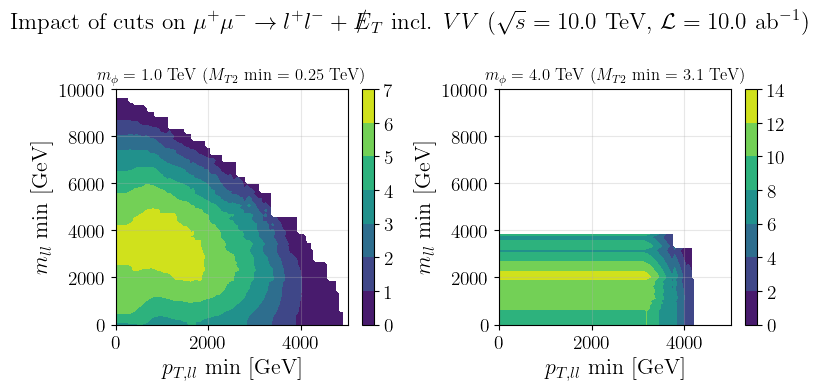

In [53]:
f_x2 = make_cross_cuts_plot_2(rts10_runs, 10e6, [2,1,5], [250, 3100])
# f_x2.savefig(FIGDIR * "ptll_mll_MT2_rts=10.pdf")
f_x2

## Maximize over cuts:

In [6]:
function get_run_at_mphi(rts_runs, mphi_tev)
    mphi_gev = mphi_tev*1e3

    idx = 0

    for (i,m) in enumerate(rts_runs.mphis)
        if m == mphi_gev
            idx = i
        end
    end

    return (rts=rts_runs.rts, mphi=rts_runs.mphis[idx],
    bkg_summary=rts_runs.bkg_summary, bkg_xsec=rts_runs.bkg_xsec,
    mumu_summary=rts_runs.mumu_summaries[idx],
    mumu_xsec=rts_runs.mumu_xsecs[idx], vv_summary=rts_runs.vv_summaries[idx],
    vv_xsec=rts_runs.vv_xsecs[idx])
end

rts10_mphi4_run = get_run_at_mphi(rts10_runs, 4)
rts10_mphi45_run = get_run_at_mphi(rts10_runs, 4.5)
rts10_mphi1_run = get_run_at_mphi(rts10_runs, 1)
rts3_mphi1_run = get_run_at_mphi(rts3_runs, 1)
rts3_mphi13_run = get_run_at_mphi(rts3_runs, 1.3)
;

In [7]:
function fraction_cuts(summary, mins)
    min_mll = mins[1]
    min_ptll = mins[2]
    min_mt2 = mins[3]

    frac_cut = sum((summary[1,:] .> min_mll) .&& (summary[2,:] .> min_ptll)
                    .&& (summary[5,:] .> min_mt2)) ./ length(summary[1,:])
    
    return frac_cut
end

function N_signal(run, lumi, mins)
    N_mumu = run.mumu_xsec * lumi * fraction_cuts(run.mumu_summary, mins)
    N_vv = run.vv_xsec * lumi * fraction_cuts(run.vv_summary, mins)

    return N_mumu+N_vv
end

function N_background(run, lumi, mins)
    N_bkg = run.bkg_xsec * lumi * fraction_cuts(run.bkg_summary, mins)
end

function significance(run, lumi, mins)
    mumu_frac = fraction_cuts(run.mumu_summary, mins)
    vv_frac = fraction_cuts(run.vv_summary, mins)
    bkg_frac = fraction_cuts(run.bkg_summary, mins)

    N_mumu = run.mumu_xsec * lumi * mumu_frac
    N_vv = run.vv_xsec * lumi * vv_frac
    N_bkg_true = run.bkg_xsec * lumi * bkg_frac
    N_bkg = N_bkg_true .+ ((N_bkg_true .<= 2.0)*2.0)

    N_S = N_mumu + N_vv

    if N_S <= 20
        N_S = 0.0
    end

    return N_S / sqrt(N_bkg)
end
;

### Optim.jl

In [37]:
function dN_dcuts(Nfn, run, lumi, mins)
    dmins = Diagonal(mins .* 1e-4)
    res = [(Nfn(run, lumi, mins .+ dmins[i,:]) - 
           Nfn(run, lumi, mins .- dmins[i,:])) / dmins[i,i]
           for i in 1:3]
    return res
end

function find_best_cuts(run, lumi)
    init_cuts = [run.rts/2, run.rts/4, run.mphi/2]

    # neg_signif(mins) = -significance(run, lumi, mins)
    neg_signif(mins) = N_background(run, lumi, mins) - N_signal(run, lumi, mins)

    lower = fill(200.0, 3)
    upper = [run.rts, run.rts/2, run.mphi]

    res2 = optimize(neg_signif, lower, upper, init_cuts, Fminbox(NelderMead()))

    res = optimize(neg_signif, lower, upper, Optim.minimizer(res2), SAMIN(rt=0.95), Optim.Options(iterations=10^8))

    return Optim.minimizer(res), -minimum(res)
end
;

In [8]:
function make_table(rts_runs, lumi)
    runs = get_run_at_mphi.((rts_runs,), 1e-3 .* [rts_runs.mphis[1], rts_runs.mphis[end]])
    bests = find_best_cuts.(runs, lumi)

    best_cuts = [bests[1][1], (bests[2][1] .+ bests[1][1]) ./ 2, bests[2][1]]

    return best_cuts
end
;

In [35]:
function check_min(run, lumi, cuts)
    res = zeros(Bool, length(cuts))
    for i in 1:length(cuts)
        tester = cuts[:]
        tester[i] = 200.0
        if significance(run, lumi, tester) >= significance(run, lumi, cuts)
            res[i] = 1
        end
    end
    return res
end
;

In [38]:
run = rts10_mphi45_run
testCuts, testSig = find_best_cuts(run, 10e6)
println(testCuts)
println(testSig)
println(N_signal(run, 10e6, testCuts))
println(N_background(run, 10e6, testCuts))
println(dN_dcuts(significance, run, 10e6, [testCuts[1], testCuts[2], testCuts[3]]))
println(check_min(run, 10e6, testCuts))

[615.0329294600742, 4166.387343978075, 3337.5059830894215]
31.896264420097925
31.896264420097925
0.0


[0.0, 59.739149133829386, 74.75344253510036]
Bool[1, 0, 0]


### argmax

In [8]:
function gtr_min(summ_vec, min)
    summ_vec .> min
end

function fcut(summary, mll_min, ptll_min, mt2_min)
    N_mll = length(mll_min)
    N_ptll = length(ptll_min)
    N_mt2 = length(mt2_min)
    Nevent = length(summary[1,:])

    res = zeros(Float64, (N_mll, N_ptll, N_mt2))

    mll_test = gtr_min.((summary[1,:],), mll_min)
    ptll_test = gtr_min.((summary[2,:],), ptll_min)
    mt2_test = gtr_min.((summary[5,:],), mt2_min)

    @Threads.threads for i in 1:N_mll
        @Threads.threads for j in 1:N_ptll
            @Threads.threads for k in 1:N_mt2
                res[i,j,k] = sum(mll_test[i] .&& ptll_test[j] .&& mt2_test[k])
            end
        end
    end

    return res ./ Nevent
end
;

In [9]:
function find_best_cuts_disc(run, lumi; ncuts=50, mincut=200.0, 
                             integer_cuts=true)

    if integer_cuts
        cuts = (Vector{Int}(round.(range(mincut, run.rts, ncuts); sigdigits=2)), 
            Vector{Int}(round.(range(mincut, run.rts/2, ncuts); sigdigits=2)), 
            Vector{Int}(round.(range(mincut, run.mphi, ncuts); sigdigits=2)))
    else
        cuts = (range(mincut, run.rts, ncuts), range(mincut, run.rts/2, ncuts), 
            range(mincut, run.mphi, ncuts))
    end

    frac_mumu = fcut(run.mumu_summary, cuts...)
    frac_vv = fcut(run.vv_summary, cuts...)
    frac_bkg = fcut(run.bkg_summary, cuts...)

    N_bkg_true = run.bkg_xsec.*lumi.*frac_bkg
    N_bkg = N_bkg_true .+ ((N_bkg_true .<= 2.0)*2.0)
    bkg_err = sqrt.(N_bkg)
    N_mumu = run.mumu_xsec .* lumi .* frac_mumu
    N_vv = run.vv_xsec .* lumi .* frac_vv

    N_tot = N_mumu .+ N_vv

    for (i, n) in enumerate(N_tot)
        if n <= 20
            N_tot[i] = 0.0
        end
    end

    signif = N_tot ./ bkg_err

    idxs = argmax(signif)

    return [cuts[1][idxs[1]], cuts[2][idxs[2]], cuts[3][idxs[3]]], signif[idxs]
end

function make_table(rts_runs, lumi; ncuts=50)
    runs = get_run_at_mphi.((rts_runs,), 1e-3 .* [rts_runs.mphis[1], rts_runs.mphis[end]])
    bests = find_best_cuts_disc.(runs, lumi; ncuts=ncuts)

    best_cuts = [bests[1][1], 
                round.((bests[2][1] .+ bests[1][1]) ./ 2, sigdigits=2),
                bests[2][1]]

    nrows = 3*3*3
    sigs1_fordf = zeros(Float64, nrows)
    sigs2_fordf = zeros(Float64, nrows)
    cut1s = zeros(Int64, nrows)
    cut2s = zeros(Int64, nrows)
    cut3s = zeros(Int64, nrows)
    signal1 = zeros(Int64, nrows)
    signal2 = zeros(Int64, nrows)
    bkg1 = zeros(Int64, nrows)

    idx = 1
    for c1 in [best_cuts[i][1] for i in 1:3]
        for c2 in [best_cuts[i][2] for i in 1:3]
            for c3 in [best_cuts[i][3] for i in 1:3]
                cut1s[idx] = c1
                cut2s[idx] = c2
                cut3s[idx] = c3
                signal1[idx] = round(N_signal(runs[1], lumi, [c1, c2, c3]))
                signal2[idx] = round(N_signal(runs[2], lumi, [c1, c2, c3]))
                bkg1[idx] = round(N_background(runs[1], lumi, [c1, c2, c3]))
                sigs1_fordf[idx] = round(significance(runs[1], lumi, [c1, c2, c3]); sigdigits=3)
                sigs2_fordf[idx] = round(significance(runs[2], lumi, [c1, c2, c3]); sigdigits=3)
                idx += 1
            end
        end
    end

    mphi1_str = "mphi = $(1e-3 * rts_runs.mphis[1]) TeV"
    mphi2_str = "mphi = $(1e-3 * rts_runs.mphis[end]) TeV"

    return DataFrame("mll_min [GeV]" => cut1s, "ptll_min [GeV]" => cut2s, 
                    "mt2_min [GeV]" => cut3s,
                    "B" => bkg1,
                    "S ($mphi1_str)" => signal1,
                    "signif ($mphi1_str)" => sigs1_fordf,
                    "S ($mphi2_str)" => signal2,
                    "signif ($mphi2_str)" => sigs2_fordf)
end
;

In [ ]:
testCuts2, testSig2 = find_best_cuts_disc_2(rts10_mphi45_run, 10e6; ncuts=50)
println(testCuts2)
println(testSig2)
println(N_signal(rts10_mphi45_run, 10e6, testCuts2))
println(N_background(rts10_mphi45_run, 10e6, testCuts2))
println(significance(rts10_mphi45_run, 10e6, testCuts2))

In [14]:
make_table(rts3_runs, 1e6, ncuts=100)

Row,mll_min [GeV],ptll_min [GeV],mt2_min [GeV],B,S (mphi = 1.0 TeV),signif (mphi = 1.0 TeV),S (mphi = 1.3 TeV),signif (mphi = 1.3 TeV)
,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64
1,480,750,610,1334,287,7.85,137,3.74
2,480,750,740,877,196,6.61,120,4.04
3,480,750,880,318,66,3.7,79,4.45
4,480,480,610,2030,342,7.58,161,3.57
5,480,480,740,893,197,6.58,120,4.02
6,480,480,880,318,66,3.7,79,4.45
7,480,200,610,2030,342,7.58,161,3.57
8,480,200,740,893,197,6.58,120,4.02
9,480,200,880,318,66,3.7,79,4.45


In [11]:
CSV.write("table_2_rts=3.csv", make_table(rts3_runs, 1e6, ncuts=100))

"table_2_rts=3.csv"

### $\phi$ mass scan: best $S / \sqrt{B}$ of 27 SRs

In [15]:
function get_best_cuts(rts_runs, lumi; ncuts=50)
    runs = get_run_at_mphi.((rts_runs,), 1e-3 .* [rts_runs.mphis[1], rts_runs.mphis[end]])
    bests = find_best_cuts_disc.(runs, lumi; ncuts=ncuts)

    best_cuts = [bests[1][1], 
                round.((bests[2][1] .+ bests[1][1]) ./ 2, sigdigits=2),
                bests[2][1]]
    
    return best_cuts
end

function best_signif_mphi(best_cuts, rts_runs_scan, lumi; ncuts=50)
    
    best_mll = [best_cuts[i][1] for i in 1:3]
    best_ptll = [best_cuts[i][2] for i in 1:3]
    best_mt2 = [best_cuts[i][3] for i in 1:3]

    N_mphi_scan = length(rts_runs_scan.mphis)
    signifs = zeros(Float64, (N_mphi_scan, 3, 3, 3))

    for i in 1:N_mphi_scan
        for j in 1:3
            for k in 1:3
                for l in 1:3
                    run = get_run_at_mphi(rts_runs_scan, 1e-3*rts_runs_scan.mphis[i])
                    signifs[i,j,k,l] = significance(run, lumi, [best_mll[j],
                                        best_ptll[k], best_mt2[l]])
                end
            end
        end
    end

    best_signifs = [maximum(signifs[i,:,:,:]) for i in 1:N_mphi_scan]

    return best_signifs
end
;

In [35]:
best_cuts = get_best_cuts(rts10_runs, 10e6)

3-element Vector{Vector{Float64}}:
 [4000.0, 890.0, 200.0]
 [2100.0, 2500.0, 1800.0]
 [200.0, 4200.0, 3400.0]

In [36]:
best_signif_mphi(best_cuts, rts10_runs, 10e6)

3-element Vector{Float64}:
  6.667066988851999
  6.962755552406217
 14.510738325129424

### Cross-cuts with best 3rd cut

In [12]:
SR_table_3 = CSV.read("table_rts=3.csv", DataFrame)
SR_table_10 = CSV.read("table_rts=10.csv", DataFrame)
SR_mins_3 = [Vector(SR_table_3[i,1:3]) for i in 1:nrow(SR_table_3)];
SR_mins_10 = [Vector(SR_table_10[i,1:3]) for i in 1:nrow(SR_table_10)];

function significances(run, lumi, mll_min, ptll_min, mt2_min)
    mumu_frac = fcut(run.mumu_summary, mll_min, ptll_min, mt2_min)
    vv_frac = fcut(run.vv_summary, mll_min, ptll_min, mt2_min)
    bkg_frac = fcut(run.bkg_summary, mll_min, ptll_min, mt2_min)

    N_mumu = run.mumu_xsec .* lumi .* mumu_frac
    N_vv = run.vv_xsec .* lumi .* vv_frac
    N_bkg_true = run.bkg_xsec .* lumi .* bkg_frac
    N_bkg = N_bkg_true .+ ((N_bkg_true .<= 2.0)*2.0)

    N_S = @. (N_mumu + N_vv)

    @. N_S *= (N_S >= 20)

    return N_S ./ sqrt.(N_bkg)
end

function make_best_cross_cuts_plot(run, lumi, best_cuts; ncuts=100)
    
    cuts = (range(0, run.rts, ncuts), range(0, run.rts/2, ncuts),
            range(0, maximum(run.mphi), ncuts))

    labels = [L"$m_{\ell \ell}$ min [TeV]", L"$p_{T,\ell \ell}$ min [TeV]",
              L"$M_{T2}$ min [TeV]"]

    sigs = zeros(Float64, (3, ncuts, ncuts))
    sigs[1,:,:] = significances(run, lumi, best_cuts[1], cuts[2], cuts[3])[1,:,:]
    sigs[2,:,:] = significances(run, lumi, cuts[1], best_cuts[2], cuts[3])[:,1,:]
    sigs[3,:,:] = significances(run, lumi, cuts[1], cuts[2], best_cuts[3])[:,:,1]

    x_idxs = [3,3,2]
    y_idxs = [2,1,1]

    fig, axs = subplots(3,1, figsize=(5, 10))

    for i in 1:3
        j = i-1
        xi = x_idxs[i]
        yi = y_idxs[i]

        q = axs[j].contourf(1e-3*cuts[xi], 1e-3*cuts[yi], sigs[i,:,:], 0:2:10, extend="max")

        axs[j].set_xlabel(labels[xi])
        axs[j].set_ylabel(labels[yi])

        axs[j].grid(alpha=0.3)

        axs[j].set_title(L"%$(labels[i][1:end-6]) = %$(round(1e-3*best_cuts[i], sigdigits=2)) TeV")

        axs[j].set_aspect((cuts[xi][end]-cuts[xi][1]) / ((cuts[yi][end]-cuts[yi][1])*golden_ratio), adjustable="box")

        fig.colorbar(q, label=L"S/\sqrt{B}")
    end

    fig.suptitle(L"$m_\phi$ = %$(run.mphi*1e-3) TeV, $\sqrt{s} = %$(1e-3*run.rts)$ TeV, $\mathcal{L} = %$(lumi*1e-6)$ ab$^{-1}$",
        fontsize=16)

    # axs[0].contourf(cuts[3], cuts[2], sigs_mll)
    # axs[1].contourf(cuts[3], cuts[1], sigs_ptll)
    # axs[2].contourf(cuts[2], cuts[1], sigs_mt2)

    return fig
end
;

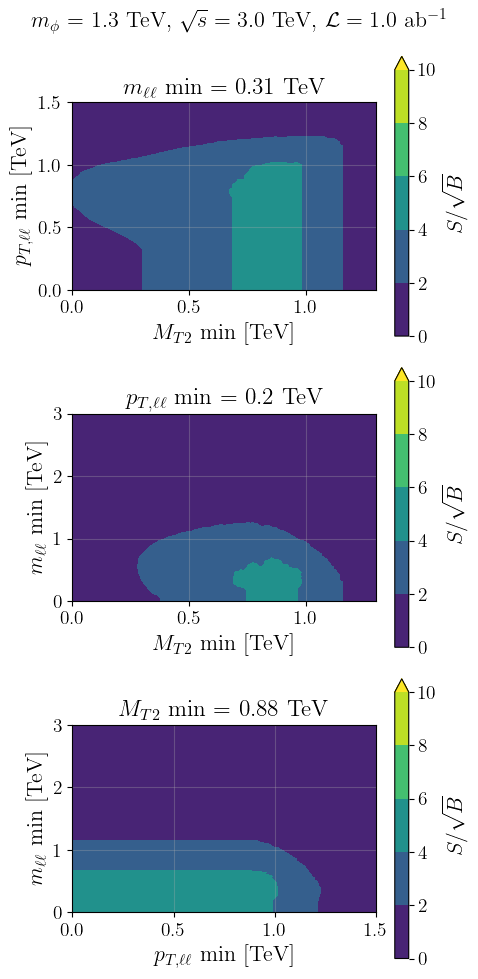

In [16]:
f = make_best_cross_cuts_plot(rts3_mphi13_run, 1e6, SR_mins_3[end])
# f.savefig(FIGDIR*"best_signif_cross_rts=10_mphi=4.5.pdf", bbox_inches="tight")
f